The purpose of this file is to identify a MyGene2 patient who has their case solved by BOCC

In [1]:
import pandas as pd
from BOCC import BOCC, load_clusters
import matplotlib.pyplot as plt
import networkx as nx
import os

### Load MyGene2 data and predicted cluster values

In [2]:
mg2_df = pd.read_csv('../Resources/my_gene_2_variantes_by_family_tables.csv')
print(mg2_df.columns)
print(mg2_df.shape)

predicted_df = pd.read_csv('../xgboost_results.csv')
print(predicted_df.columns)
print(predicted_df.shape)

Index(['Unnamed: 0', 'gene', 'variant_id', 'family_id', 'family_url',
       'inheritance', 'phenotype_name', 'phenotype_hpo_id',
       'confidence_in_pathogenicity'],
      dtype='object')
(21455, 9)
Index(['cluster_origin', 'bocc_origin', 'cluster_method', 'subcluster_method',
       'year', 'IDs', 'predicted_snowballing_pvalue', 'snowballing_pvalue',
       'max_norm_cell_type_specificity', 'max_norm_disease_specificity',
       'max_plof', 'mean_plof', 'median_plof', 'num_cell_type_string',
       'num_disease_string', 'num_of_diseases', 'num_sig_go_enrichment_terms',
       'std_plof', 'sum_plof', 'avg_embeddedness', 'avg_internal_degree',
       'cluster_size', 'conductance', 'cut_ratio', 'edges_inside', 'expansion',
       'gene_ratio', 'hub_dominance', 'internal_edge_density',
       'newman_girvan_modularity', 'normalized_cut', 'significance',
       'surprise', 'triangle_participation_ratio'],
      dtype='object')
(8017, 34)


In [3]:
# Functions for usefull stuff
def remove_borders(ax,top=True,right=True,bottom=True,left=True):
    ax.spines['top'].set_visible(not top)
    ax.spines['right'].set_visible(not right)
    ax.spines['bottom'].set_visible(not bottom)
    ax.spines['left'].set_visible(not left)

### Load all of the clusters

In [4]:
"""
Dict format
{
'paris.censa.2020':['HP:0000001','SEMA4A'...],
'paris.censa.2019':['HP:0000001','SEMA4A'...],
...
}
"""
coms_dict = {}
for dir in os.listdir('../SubComs'):
    if dir in ['2019', '2020', '2021']:
        for f in os.listdir('../SubComs/{}'.format(dir)):
            if 'paris' in f:
                coms_dict[f.replace('.coms.txt','')] = load_clusters('../SubComs/{}/{}'.format(dir,f))

### Load the Edgelist

In [5]:
G19 = nx.read_edgelist('../Edgelists/String_HPO_2019.phenotypic_branch.edgelist.txt')
G20 = nx.read_edgelist('../Edgelists/String_HPO_2020.phenotypic_branch.edgelist.txt')
G21 = nx.read_edgelist('../Edgelists/String_HPO_2021.phenotypic_branch.edgelist.txt')

### Filter MyGene2 patients to be just those that are unsolved
#### Load them all into a dict

In [6]:
# create a dict with patient keys and lists of all HPOs and genes within them
patient_map = {}
# add all the genes
for i,r in mg2_df.groupby('family_id')['gene'].agg(['unique'])['unique'].reset_index().iterrows():
    patient_map[r['family_id']] = list(r['unique'])
# add all the HPOs
for i,r in mg2_df.groupby('family_id')['phenotype_hpo_id'].agg(['unique'])['unique'].reset_index().iterrows():
    if r['family_id'] in patient_map:
            patient_map[r['family_id']] = patient_map[r['family_id']] + list(r['unique'])
print(len(patient_map))
assert(len(patient_map) == len(set(mg2_df['family_id'])))

912


#### Remove patients with only a sinlge gene

In [7]:
filtered_patient_map = {}
for key in patient_map.keys():
    if sum(['HP:' not in x for x in patient_map[key]]) > 0: # change this to > 1 to actually filter
        filtered_patient_map[key] = patient_map[key]
print(len(patient_map))
print(len(filtered_patient_map))

912
912


#### create all possible pairs for each patient

In [8]:
all_patient_pairs = {}
for key in filtered_patient_map.keys():
    genes = [x for x in patient_map[key] if 'HP:' not in x]
    hpos = [x for x in patient_map[key] if 'HP:' in x]
    all_patient_pairs[key] = [[g,h] for g in genes for h in hpos]

##### How many of these pateints do not have any edges already in the 2019 graph?

In [9]:
solved_patients = []
for key in all_patient_pairs.keys():
    for pair in all_patient_pairs[key]:
        if G21.has_edge(pair[0],pair[1]) or G21.has_edge(pair[1],pair[0]):
            solved_patients.append(key)
            break
unsolved_patients = [x for x in all_patient_pairs.keys() if x not in solved_patients]
print('Number of "unsolved" MyGene2 patients',len(unsolved_patients))

Number of "unsolved" MyGene2 patients 115


#### Create map of patient id and their genes and HPOs

In [10]:
# getting this information is just a matter of subsetting the filtered_patient_map
unsolved_patients_map = {id:filtered_patient_map[id] for id in unsolved_patients}
unsolved_patients_pairs = {id:all_patient_pairs[id] for id in unsolved_patients}

### How many of these pateints have one of their edges discovered in a cluster?

In [11]:
# {101:['paris.censa.2021:1:SEMA4A,HP:0000128']} patient_id:list of ids of com this patient was solved by:gene,HPO
newly_solved_patients = {}
for pid in unsolved_patients_pairs:
    # is this pid's pairs in any of the coms?
    for pair in unsolved_patients_pairs[pid]:
        # for each community sets keys are in formatted like 'paris.cesna.2021'
        for k in coms_dict.keys():
            if '2021' not in k:
                continue
            for com in coms_dict[k]:
                if pair[0] in com.members and pair[1] in com.members:
                    res_string = '{pid}\t{node1}\t{node2}\t{cluster_set}:{cluster_id}'.format(cluster_set=k,
                                                                                     cluster_id=str(com.name),
                                                                                     node1=pair[0],
                                                                                     node2=pair[1],pid=pid)
                    print(res_string, pid, pair)
                    if pid in newly_solved_patients:
                        newly_solved_patients[pid].append(res_string)
                    else:
                        newly_solved_patients[pid] = [res_string]
                    

print('Number of patients solved by one of these communities', len(newly_solved_patients)) 

1292	TNNT3	HP:0002804	paris.walktrap.2021:1321 1292 ['TNNT3', 'HP:0002804']
1292	TNNT3	HP:0002804	paris.greedy.2021:968 1292 ['TNNT3', 'HP:0002804']
1635	SPTBN5	HP:0001250	paris.cesna.2021:22018 1635 ['SPTBN5', 'HP:0001250']
1922	FAT2	HP:0001310	paris.cesna.2021:15553 1922 ['FAT2', 'HP:0001310']
1930	NBEA	HP:0001824	paris.walktrap.2021:84 1930 ['NBEA', 'HP:0001824']
1932	HUWE1	HP:0000739	paris.cesna.2021:9175 1932 ['HUWE1', 'HP:0000739']
1943	SHANK2	HP:0011968	paris.cesna.2021:3199 1943 ['SHANK2', 'HP:0011968']
1948	CHD2	HP:0001250	paris.cesna.2021:9175 1948 ['CHD2', 'HP:0001250']
1950	SATB2	HP:0001999	paris.cesna.2021:14105 1950 ['SATB2', 'HP:0001999']
1950	SATB2	HP:0000202	paris.cesna.2021:5816 1950 ['SATB2', 'HP:0000202']
2197	C17orf62	HP:0006532	paris.cesna.2021:6379 2197 ['C17orf62', 'HP:0006532']
2197	C17orf62	HP:0001744	paris.cesna.2021:6379 2197 ['C17orf62', 'HP:0001744']
2234	DROSHA	HP:0000252	paris.cesna.2021:24074 2234 ['DROSHA', 'HP:0000252']
2527	TRAPPC5	HP:0000011	paris.w

#### How many of their unique pairs were matched by our clusters? It is possible that a pair was picked up by multiple communities.

[2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 4]


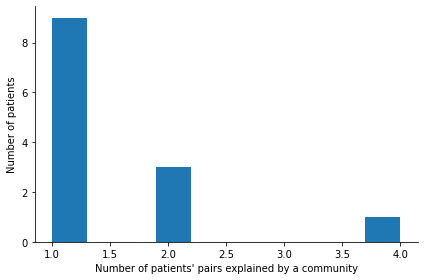

In [12]:
pairs_per_patient = [len(set([ p.split(':')[-1] for p in newly_solved_patients[pid]])) for pid in newly_solved_patients.keys()]
print(pairs_per_patient)
fig, ax = plt.subplots()
ax.hist(pairs_per_patient)
ax.set_xlabel('Number of patients\' pairs explained by a community')
ax.set_ylabel('Number of patients')
remove_borders(ax, bottom=False, left=False)
plt.tight_layout()
plt.savefig('../Figures/mg2_results_unsolved_patient_pairs_explained_hist.png',dpi=300)
plt.show()

#### How many of the pairs are discovered by multiple clusters?

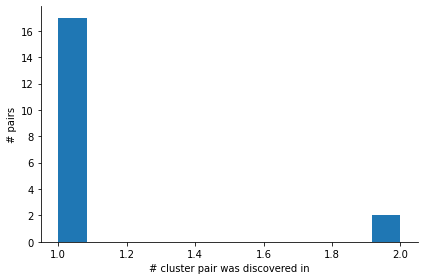

In [13]:
pair_counts = []
for pid in newly_solved_patients.keys():
    # how many times is each pair discovered?
    pairs = [res.split(':')[-1] for res in newly_solved_patients[pid]]
    tmp_pair_map = {res.split(':')[-1]:res for res in newly_solved_patients[pid]}
    tmp_pair_counts = []
    for p in set(pairs):
#         print(tmp_pair_map[p],pairs.count(p))
        tmp_pair_counts.append(pairs.count(p))
    pair_counts = pair_counts + tmp_pair_counts

fig, ax = plt.subplots()
ax.hist(pair_counts,bins=12)
ax.set_xlabel('# cluster pair was discovered in')
ax.set_ylabel('# pairs')
remove_borders(ax,bottom=False,left=False)
plt.tight_layout()
plt.savefig('../Figures/mg2_results_unsolved_patient_pairs_coms_membership_count.png',dpi=300)
plt.show()

In [14]:
for pid in newly_solved_patients.keys():
    print(pid)

1292
1635
1922
1930
1932
1943
1948
1950
2197
2234
2527
2584
27


## 2020 Results

In [15]:
# filter the clusters so only the ones predicted as significant are included in the search
predicted_df = pd.read_csv('../xgboost_results.csv')
print(predicted_df.columns)
print(predicted_df.shape)
predicted_df = predicted_df.sort_values('predicted_snowballing_pvalue')
predicted_df = predicted_df[predicted_df['year'] == 2020]
sig_df = predicted_df.iloc[:1898,:]
#paris.censa.2021:1
sig_df['UID'] = sig_df['subcluster_method'] + '.' + sig_df['subcluster_method']  + '.' + sig_df['year'].astype(str) + ':' + sig_df['IDs'].astype(str)
print(sig_df)


Index(['cluster_origin', 'bocc_origin', 'cluster_method', 'subcluster_method',
       'year', 'IDs', 'predicted_snowballing_pvalue', 'snowballing_pvalue',
       'max_norm_cell_type_specificity', 'max_norm_disease_specificity',
       'max_plof', 'mean_plof', 'median_plof', 'num_cell_type_string',
       'num_disease_string', 'num_of_diseases', 'num_sig_go_enrichment_terms',
       'std_plof', 'sum_plof', 'avg_embeddedness', 'avg_internal_degree',
       'cluster_size', 'conductance', 'cut_ratio', 'edges_inside', 'expansion',
       'gene_ratio', 'hub_dominance', 'internal_edge_density',
       'newman_girvan_modularity', 'normalized_cut', 'significance',
       'surprise', 'triangle_participation_ratio'],
      dtype='object')
(8017, 34)
                                         cluster_origin  \
1520  Data/SubClusters/2020/louvain.cesna.2020.coms.txt   
31    Data/SubClusters/2020/louvain.cesna.2020.coms.txt   
3025    Data/SubClusters/2020/paris.cesna.2020.coms.txt   
4364    Data/Su

/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_88728/1272666798.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_df['UID'] = sig_df['subcluster_method'] + '.' + sig_df['subcluster_method']  + '.' + sig_df['year'].astype(str) + ':' + sig_df['IDs'].astype(str)


In [36]:
# filter the clusters so only the ones predicted as significant are included in the search


def get_res(_year,_unsolved_patients_pairs,_coms_dict,_sig_df,_g8r_1_genes=False):
    _filtered_patient_map = {}
    for _key in _unsolved_patients_pairs.keys():
        _thresh = 0
        if _g8r_1_genes:
            _thresh = 1
        if sum(['HP:' not in x for x in _unsolved_patients_pairs[_key]]) > _thresh:
            _filtered_patient_map[_key] = _unsolved_patients_pairs[_key]

    # {101:['paris.censa.2021:1:SEMA4A,HP:0000128']} patient_id:list of ids of com this patient was solved by:gene,HPO
    _newly_solved_patients = {}
    for _pid in _unsolved_patients_pairs:
        if 'family_id' in _pid:
            continue
        # is this pid's pairs in any of the coms?
        for _pair in _filtered_patient_map[_pid]:
            # for each community sets keys are in formatted like 'paris.cesna.2021'
            for _k in _coms_dict.keys():
                if _year not in _k:
                    continue
#                 print(len(_coms_dict))
#                 print(len(_coms_dict[_k]))
                for _com in _coms_dict[_k]:
                    _uid  = '{}:{}'.format(_k,str(_com.name))
#                     if _uid in _sig_df['UID'] and _pair[0] in _com.members and _pair[1] in _com.members:
                    if _pair[0] in _com.members and _pair[1] in _com.members:
                        _res_string = '{pid}\t{node1}\t{node2}\t{cluster_set}:{cluster_id}'.format(cluster_set=_k,
                                                                                         cluster_id=str(_com.name),
                                                                                         node1=_pair[0],
                                                                                         node2=_pair[1],
                                                                                         pid=_pid)
                        print(_res_string, _pid, _pair)
                        if _pid in _newly_solved_patients:
                            _newly_solved_patients[_pid].append(_res_string)
                        else:
                            _newly_solved_patients[_pid] = [_res_string]


    print('Number of patients solved by one of these communities', len(_newly_solved_patients)) 
    for _pid in _newly_solved_patients.keys():
        print(_pid)
get_res('2020',unsolved_patients_pairs,coms_dict,sig_df,_g8r_1_genes=False)

KeyboardInterrupt: 

## Prediction Results on 2021

In [44]:
pred_df = pd.read_csv('../predictions_from_2019_fit.csv')
print(pred_df.shape)
pred_df = pred_df[pred_df['year'] == 2021]
print(pred_df.shape)
print(pred_df.columns)
pred_df = pred_df.sort_values('predicted_snowballing_pvalue')
filtered_pred_df = pred_df[pred_df['subcluster_method'] == 'paris']
filtered_pred_df = filtered_pred_df[filtered_pred_df['cluster_method'] != 'paris']

top_pred_df = filtered_pred_df.iloc[:1898,:]
top_pred_df['UID'] = top_pred_df['subcluster_method'] + '.' + top_pred_df['cluster_method']  + '.' + top_pred_df['year'].astype(str) + ':' + top_pred_df['IDs'].astype(str)
print(top_pred_df.shape)
get_res('2021',unsolved_patients_pairs,coms_dict,top_pred_df,_g8r_1_genes=False)


(17195, 34)
(9178, 34)
Index(['predicted_snowballing_pvalue', 'snowballing_pvalue', 'cluster_origin',
       'bocc_origin', 'year', 'cluster_method', 'subcluster_method', 'IDs',
       'max_norm_cell_type_specificity', 'max_norm_disease_specificity',
       'max_plof', 'mean_plof', 'median_plof', 'num_cell_type_string',
       'num_disease_string', 'num_of_diseases', 'num_sig_go_enrichment_terms',
       'std_plof', 'sum_plof', 'avg_embeddedness', 'avg_internal_degree',
       'cluster_size', 'conductance', 'cut_ratio', 'edges_inside', 'expansion',
       'gene_ratio', 'hub_dominance', 'internal_edge_density',
       'newman_girvan_modularity', 'normalized_cut', 'significance',
       'surprise', 'triangle_participation_ratio'],
      dtype='object')
(1898, 35)


/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_88728/3709743817.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_pred_df['UID'] = top_pred_df['subcluster_method'] + '.' + top_pred_df['cluster_method']  + '.' + top_pred_df['year'].astype(str) + ':' + top_pred_df['IDs'].astype(str)


Number of patients solved by one of these communities 0


## Create list of clusters that are predicted to be significant and their members 

In [46]:

def get_sign_clusters(_pred_df, _year, _coms_dict, _cut_off=1898):
    """
    returns a dictionary of cluster UID: BOCC objects
    """
    # get just the desired year
    _df = _pred_df[_pred_df['year'] == _year]
    # filter out things that are not paris crosses
    _df = _df[_df['subcluster_method'] == 'paris']
    _df = _df[_df['cluster_method'] != 'paris']
    # sort values so smallest "p-values" are at the top
    _df = _df.sort_values('predicted_snowballing_pvalue')
    # keep just the top 1898
    _df = _df.iloc[:_cut_off,:]
    # create universal id for clusters
    _df['UID'] = _df['subcluster_method'] + '.' +  _df['cluster_method']  + '.' +  _df['year'].astype(str) + ':' + _df['IDs'].astype(str)
    # creat a dictionary of the significant clusters members
    _res = {}
    print(_df.columns)
    for _i,_row in _df.iterrows(): 
        key = 'paris.{al}.{y}'.format(al=_row['cluster_method'],y=str(_row['year']))
        _res[_row['UID']] = _coms_dict[key][_row['IDs']]      
    return _res


pred_coms_2021 = get_sign_clusters(_pred_df=pred_df, _year=2021, _coms_dict= coms_dict)




Index(['predicted_snowballing_pvalue', 'snowballing_pvalue', 'cluster_origin',
       'bocc_origin', 'year', 'cluster_method', 'subcluster_method', 'IDs',
       'max_norm_cell_type_specificity', 'max_norm_disease_specificity',
       'max_plof', 'mean_plof', 'median_plof', 'num_cell_type_string',
       'num_disease_string', 'num_of_diseases', 'num_sig_go_enrichment_terms',
       'std_plof', 'sum_plof', 'avg_embeddedness', 'avg_internal_degree',
       'cluster_size', 'conductance', 'cut_ratio', 'edges_inside', 'expansion',
       'gene_ratio', 'hub_dominance', 'internal_edge_density',
       'newman_girvan_modularity', 'normalized_cut', 'significance',
       'surprise', 'triangle_participation_ratio', 'UID'],
      dtype='object')
dict_keys(['paris.cesna.2021:24084', 'paris.cesna.2021:3959', 'paris.cesna.2021:44', 'paris.cesna.2021:25925', 'paris.cesna.2021:5486', 'paris.cesna.2021:7547', 'paris.cesna.2021:13279', 'paris.cesna.2021:3272', 'paris.cesna.2021:9527', 'paris.cesna.2021:

In [54]:
# score MyGene2 with a dictionary returned from get_sign_clusters
# for each MyGene2 patient
def find_solved_pairs(_unsolved_patients_pairs, _pred_coms):
    """
    @param _unsolved_patients_pairs dictionary of MyGene2 patients that have not yet been solved and all their pairs
    @param _pred_coms dictionary of clusters predicted to be significant as made by get_sign_clusters()
    return None, prints output
    """
    solved_pid_set = set()
    solved_pairs_set = set()
    for _pid in _unsolved_patients_pairs.keys():
        # for each of their pairs
        for _pair in _unsolved_patients_pairs[_pid]:
            # for each sign cluster, check for the existance of the pair
            for _uid in _pred_coms.keys():
                _com = _pred_coms[_uid]
                if _pair[0] in _com.members and _pair[1] in _com.members:
                    print('{pid}\t{uid}\t{node1}\t{node2}'.format(pid=_pid,uid=_uid,node1=_pair[0],node2=_pair[1]))
                    solved_pid_set.add(_pid)
                    solved_pairs_set.add(str(_pair))
    print('Number of MyGene2 patients solved ',str(len(solved_pid_set)))
    print('Number of MyGene2 PAIRS solved ',str(len(solved_pairs_set)))

find_solved_pairs(_unsolved_patients_pairs=unsolved_patients_pairs, _pred_coms=pred_coms_2021)

1635	paris.cesna.2021:22018	SPTBN5	HP:0001250
1932	paris.cesna.2021:9175	HUWE1	HP:0000739
1943	paris.cesna.2021:3199	SHANK2	HP:0011968
1948	paris.cesna.2021:9175	CHD2	HP:0001250
1950	paris.cesna.2021:14105	SATB2	HP:0001999
1950	paris.cesna.2021:5816	SATB2	HP:0000202
2197	paris.cesna.2021:6379	C17orf62	HP:0006532
2197	paris.cesna.2021:6379	C17orf62	HP:0001744
2234	paris.cesna.2021:24074	DROSHA	HP:0000252
2584	paris.cesna.2021:24123	PYROXD1	HP:0003715
2584	paris.cesna.2021:24123	PYROXD1	HP:0003198
27	paris.cesna.2021:21373	SCN2A	HP:0001250
27	paris.cesna.2021:15778	SCN2A	HP:0001250
27	paris.cesna.2021:24273	SCN2A	HP:0001250
Number of MyGene2 patients solved  9
Number of MyGene2 PAIRS solved  12


In [53]:
def find_res(_unsolved_patients_pairs, _cut_off=1898):
    """
    @param _unsolved_patients_pairs dictionary of MyGene2 patients that have not yet been solved and all their pairs
    @param _cut_off the number of top scoring clusters to keep
    """
    print('2020')
    _pred_coms = get_sign_clusters(_pred_df=pred_df, _year=2020, _coms_dict= coms_dict)
    find_solved_pairs(_unsolved_patients_pairs=_unsolved_patients_pairs, _pred_coms=_pred_coms)
    print('2021')
    _pred_coms = get_sign_clusters(_pred_df=pred_df, _year=2021, _coms_dict= coms_dict)
    find_solved_pairs(_unsolved_patients_pairs=_unsolved_patients_pairs, _pred_coms=_pred_coms)


find_res(_unsolved_patients_pairs=unsolved_patients_pairs,  _cut_off=1898)

2020
Index(['predicted_snowballing_pvalue', 'snowballing_pvalue', 'cluster_origin',
       'bocc_origin', 'year', 'cluster_method', 'subcluster_method', 'IDs',
       'max_norm_cell_type_specificity', 'max_norm_disease_specificity',
       'max_plof', 'mean_plof', 'median_plof', 'num_cell_type_string',
       'num_disease_string', 'num_of_diseases', 'num_sig_go_enrichment_terms',
       'std_plof', 'sum_plof', 'avg_embeddedness', 'avg_internal_degree',
       'cluster_size', 'conductance', 'cut_ratio', 'edges_inside', 'expansion',
       'gene_ratio', 'hub_dominance', 'internal_edge_density',
       'newman_girvan_modularity', 'normalized_cut', 'significance',
       'surprise', 'triangle_participation_ratio', 'UID'],
      dtype='object')
2021
Index(['predicted_snowballing_pvalue', 'snowballing_pvalue', 'cluster_origin',
       'bocc_origin', 'year', 'cluster_method', 'subcluster_method', 'IDs',
       'max_norm_cell_type_specificity', 'max_norm_disease_specificity',
       'max_plof'

In [35]:


with open('../WebPage/all_predicted_sign_clusters.2021.txt','w') as outfile:
    for i,row in top_pred_df.iterrows():
        if row['year'] != 2021:
            continue
        key = 'paris.{al}.{y}'.format(al=row['cluster_method'],y=str(row['year']))
        line = row['UID'] + '\t' + '\t'.join(coms_dict[key][row['IDs']].members) + '\n'
        outfile.write(line)

paris.paris.2021:24084
paris.paris.2021:3959
paris.paris.2021:44
paris.paris.2021:25925
paris.paris.2021:5486
paris.paris.2021:7547
paris.paris.2021:13279
paris.paris.2021:3272
paris.paris.2021:9527
paris.paris.2021:21998
paris.paris.2021:13278
paris.paris.2021:6269
paris.paris.2021:13336
paris.paris.2021:25709
paris.paris.2021:8122
paris.paris.2021:50
paris.paris.2021:17821
paris.paris.2021:14979
paris.paris.2021:3035
paris.paris.2021:23157
paris.paris.2021:18241
paris.paris.2021:13370
paris.paris.2021:22882
paris.paris.2021:7368
paris.paris.2021:7546
paris.paris.2021:15809
paris.paris.2021:9330
paris.paris.2021:23951
paris.paris.2021:2826
paris.paris.2021:22575
paris.paris.2021:21428
paris.paris.2021:21429
paris.paris.2021:2245
paris.paris.2021:4754
paris.paris.2021:11667
paris.paris.2021:16853
paris.paris.2021:5147
paris.paris.2021:20145
paris.paris.2021:11584
paris.paris.2021:11939
paris.paris.2021:18755
paris.paris.2021:24336
paris.paris.2021:5146
paris.paris.2021:26215
paris.pari

paris.paris.2021:23937
paris.paris.2021:7868
paris.paris.2021:2066
paris.paris.2021:23742
paris.paris.2021:13401
paris.paris.2021:21904
paris.paris.2021:22668
paris.paris.2021:1857
paris.paris.2021:17639
paris.paris.2021:16466
paris.paris.2021:4633
paris.paris.2021:13597
paris.paris.2021:12793
paris.paris.2021:14753
paris.paris.2021:10773
paris.paris.2021:1922
paris.paris.2021:15375
paris.paris.2021:26409
paris.paris.2021:13229
paris.paris.2021:852
paris.paris.2021:527
paris.paris.2021:23165
paris.paris.2021:3867
paris.paris.2021:1655
paris.paris.2021:7015
paris.paris.2021:7676
paris.paris.2021:16159
paris.paris.2021:8928
paris.paris.2021:25756
paris.paris.2021:16349
paris.paris.2021:6081
paris.paris.2021:593
paris.paris.2021:22586
paris.paris.2021:1952
paris.paris.2021:2346
paris.paris.2021:5761
paris.paris.2021:784
paris.paris.2021:19860
paris.paris.2021:2102
paris.paris.2021:2052
paris.paris.2021:4842
paris.paris.2021:24696
paris.paris.2021:23513
paris.paris.2021:2161
paris.paris.20

paris.paris.2021:16003
paris.paris.2021:26245
paris.paris.2021:1938
paris.paris.2021:17987
paris.paris.2021:21574
paris.paris.2021:24940
paris.paris.2021:8233
paris.paris.2021:8
paris.paris.2021:14598
paris.paris.2021:929
paris.paris.2021:728
paris.paris.2021:8734
paris.paris.2021:13159
paris.paris.2021:7264
paris.paris.2021:5721
paris.paris.2021:13999
paris.paris.2021:23741
paris.paris.2021:700
paris.paris.2021:482
paris.paris.2021:22597
paris.paris.2021:956
paris.paris.2021:1309
paris.paris.2021:14284
paris.paris.2021:20326
paris.paris.2021:26396
paris.paris.2021:277
paris.paris.2021:602
paris.paris.2021:12502
paris.paris.2021:18212
paris.paris.2021:1091
paris.paris.2021:738
paris.paris.2021:20756
paris.paris.2021:5964
paris.paris.2021:4492
paris.paris.2021:1751
paris.paris.2021:13556
paris.paris.2021:11984
paris.paris.2021:3233
paris.paris.2021:3398
paris.paris.2021:2068
paris.paris.2021:3539
paris.paris.2021:10644
paris.paris.2021:22463
paris.paris.2021:3279
paris.paris.2021:23974
